In [1]:
%load_ext nb_black

import sys, os, re
from pathlib import Path

main_folder = str(Path.cwd().parent)
sys.path.append(main_folder)

from collections import Counter
import itertools

from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)

import evaluate

from src.keywords import *

/home/mfw9sw/.local/lib/python3.11/site-packages/torch/cuda/__init__.py:611: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Found cached dataset md_gender_bias (/scratch/mfw9sw/hfhub_cache/md_gender_bias/gendered_words/1.0.0/8ae77b51acf93383161cc954b146159291beca6c979b54ce228c46db86116c05)


  0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

In [4]:
def determine_gender(paragraph):

    words = re.findall(r"\b\w+\b", paragraph.lower())
    male_matches = list(set([word for word in words if word in male_words]))
    female_matches = list(set([word for word in words if word in female_words]))

    if male_matches and female_matches:
        return "both", male_matches + female_matches
    elif male_matches:
        return "male", male_matches
    elif female_matches:
        return "female", female_matches
    else:
        return "neutral", []


def determine_occupation(paragraph):

    words = re.findall(r"\b\w+\b", paragraph.lower())
    male_matches = list(set([word for word in words if word in male_occupations]))
    female_matches = list(set([word for word in words if word in female_occupations]))
    neutral_matches = list(set([word for word in words if word in neutral_occupations]))

    if male_matches and female_matches:
        return "both", male_matches + female_matches
    elif male_matches:
        return "male", male_matches
    elif female_matches:
        return "female", female_matches
    elif neutral_matches:
        return "neutral", neutral_matches
    else:
        return "no_match", []


def determine_religion(paragraph):

    words = re.findall(r"\b\w+\b", paragraph.lower())
    rel_matches = list(set([word for word in words if word in religions]))

    if rel_matches:
        return "religion", rel_matches
    else:
        return "no_match", []


def determine_race(paragraph):

    words = re.findall(r"\b\w+\b", paragraph.lower())
    race_matches = list(set([word for word in words if word in races]))

    if race_matches:
        return "race", race_matches
    else:
        return "no_match", []


def plot_list_distribution(df, col):

    all_matched_words = list(itertools.chain.from_iterable(df[col]))

    # Count the frequency of each word
    word_counts = Counter(all_matched_words)

    # Convert the word counts to a DataFrame for easier plotting
    word_counts_df = pd.DataFrame.from_dict(
        word_counts, orient="index", columns=["count"]
    )
    word_counts_df.index.name = "word"
    word_counts_df.reset_index(inplace=True)

    # Sort the DataFrame by count
    word_counts_df = word_counts_df.sort_values(by="count", ascending=False)

    if col == "matched_race":

        threshold = 0.01
        total_count = word_counts_df["count"].sum()
        threshold_count = total_count * threshold
        mask = word_counts_df["count"] < threshold_count

        # Update labels where the mask is True
        word_counts_df.loc[mask, "word"] = "other"

    # Create bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(word_counts_df["word"], word_counts_df["count"], color="skyblue")
    plt.xlabel("Word")
    plt.ylabel("Frequency")
    plt.title("Frequency of Matched Words")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()


def plot_wordcloud(word_lst, title):

    wordcloud = WordCloud(width=600, height=400, background_color="white").generate(
        " ".join(word_lst)
    )

    # Display the word cloud
    plt.figure(figsize=(8, 6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud of Matched Words - {title}")
    plt.axis("off")
    plt.show()


def load_data(data_name):

    if data_name == "dolly":

        data_id = "databricks/databricks-dolly-15k"
        data = load_dataset(data_id, cache_dir="/scratch/mfw9sw/hfhub_cache/")
        df = pd.DataFrame(data["train"])
        df["input_text"] = df.apply(
            lambda x: x["instruction"] + " " + x["context"] + " " + x["response"],
            axis=1,
        )
        print("data shape:", df.shape)

    if data_name == "alpaca":

        data_id = "yahma/alpaca-cleaned"
        data = load_dataset(data_id, cache_dir="/scratch/mfw9sw/hfhub_cache/")
        df = pd.DataFrame(data["train"])
        df["input_text"] = df.apply(
            lambda x: x["instruction"] + " " + x["input"] + " " + x["output"],
            axis=1,
        )

    return df

<IPython.core.display.Javascript object>

In [5]:
data_name = "dolly"

df = load_data(data_name)
df["gender"], df["matched_gender"] = zip(*df["input_text"].apply(determine_gender))
df["occupation"], df["matched_occup"] = zip(
    *df["input_text"].apply(determine_occupation)
)
df["religion"], df["matched_rel"] = zip(*df["input_text"].apply(determine_religion))
df["race"], df["matched_race"] = zip(*df["input_text"].apply(determine_race))

Found cached dataset json (/scratch/mfw9sw/hfhub_cache/databricks___json/databricks--databricks-dolly-15k-7427aa6e57c34282/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

data shape: (15011, 5)


<IPython.core.display.Javascript object>

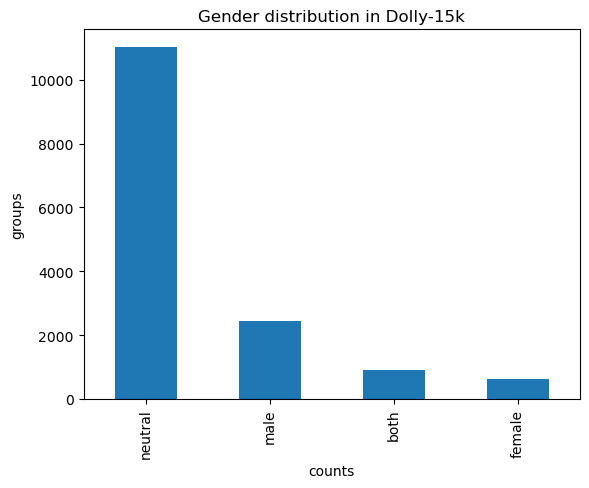

<IPython.core.display.Javascript object>

In [6]:
df["gender"].value_counts().plot(kind="bar")
plt.title("Gender distribution in Dolly-15k")
plt.xlabel("counts")
plt.ylabel("groups")
plt.show()

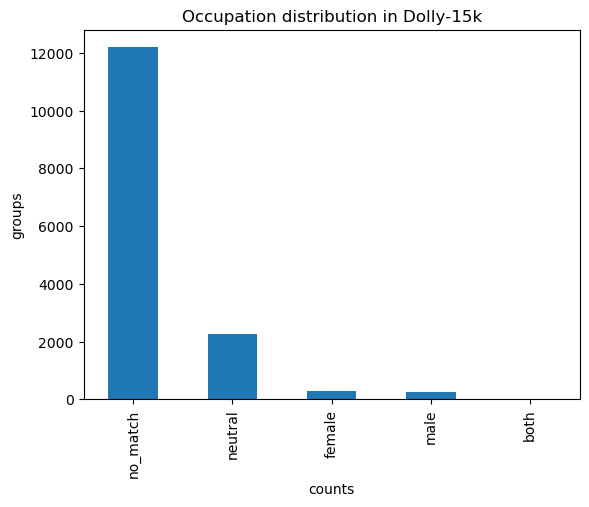

<IPython.core.display.Javascript object>

In [7]:
df["occupation"].value_counts().plot(kind="bar")
plt.title("Occupation distribution in Dolly-15k")
plt.xlabel("counts")
plt.ylabel("groups")
plt.show()

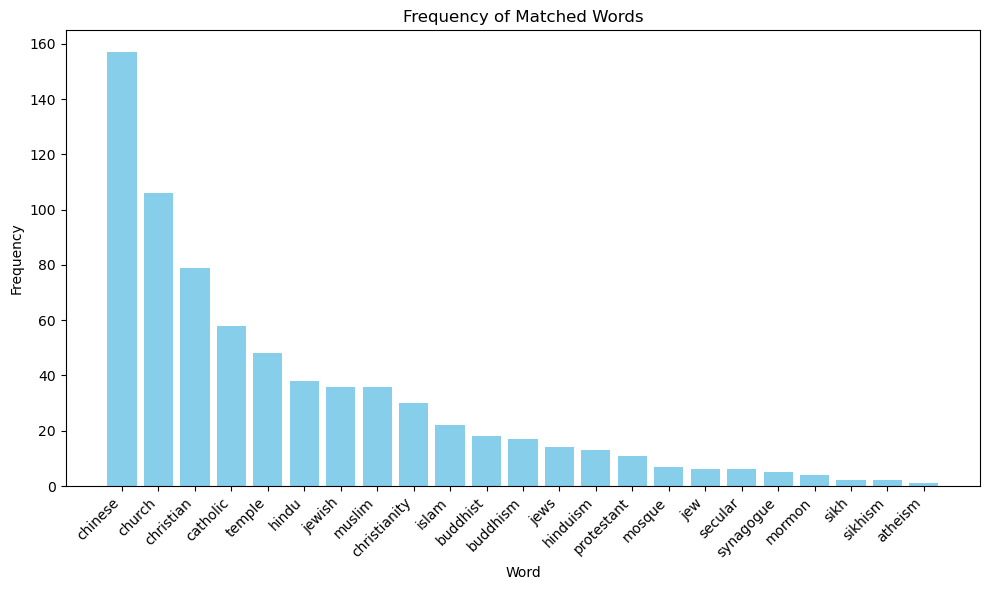

<IPython.core.display.Javascript object>

In [8]:
plot_list_distribution(df, "matched_rel")

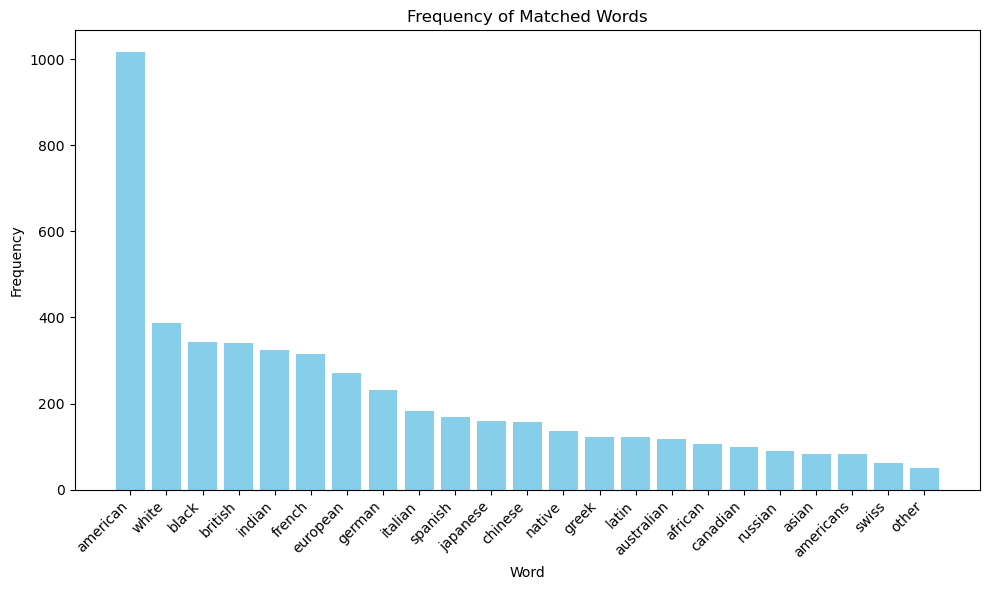

<IPython.core.display.Javascript object>

In [9]:
plot_list_distribution(df, "matched_race")

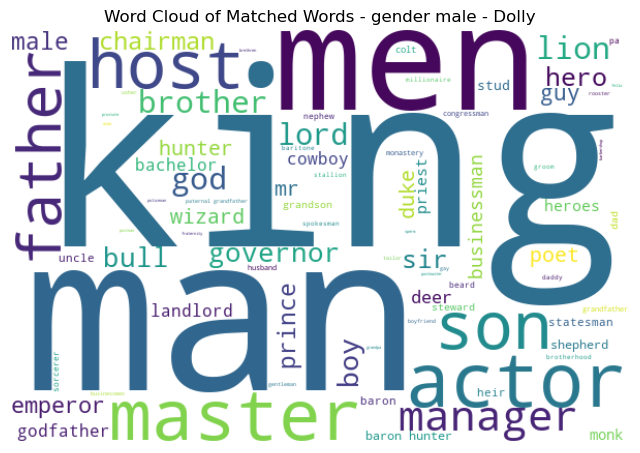

<IPython.core.display.Javascript object>

In [10]:
genders = df[df["gender"] == "male"]["matched_gender"]
genders = list(itertools.chain.from_iterable(genders))
plot_wordcloud(genders, "gender male - Dolly")

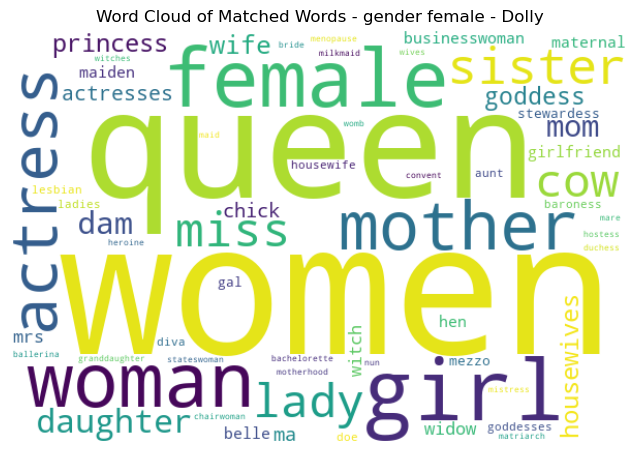

<IPython.core.display.Javascript object>

In [11]:
genders = df[df["gender"] == "female"]["matched_gender"]
genders = list(itertools.chain.from_iterable(genders))
plot_wordcloud(genders, "gender female - Dolly")

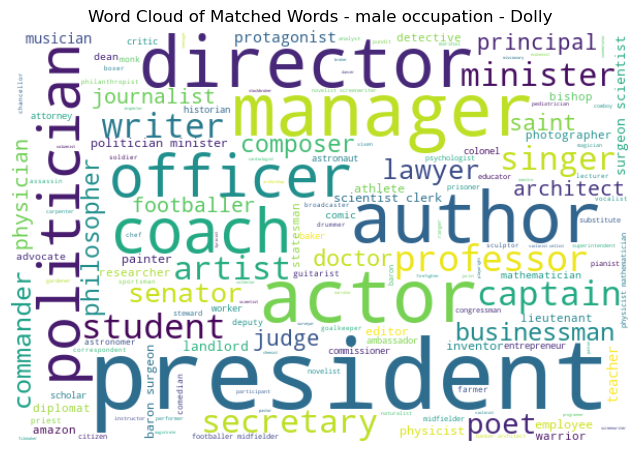

<IPython.core.display.Javascript object>

In [12]:
genders = df[df["gender"] == "male"]["matched_occup"]
genders = list(itertools.chain.from_iterable(genders))
plot_wordcloud(genders, "male occupation - Dolly")

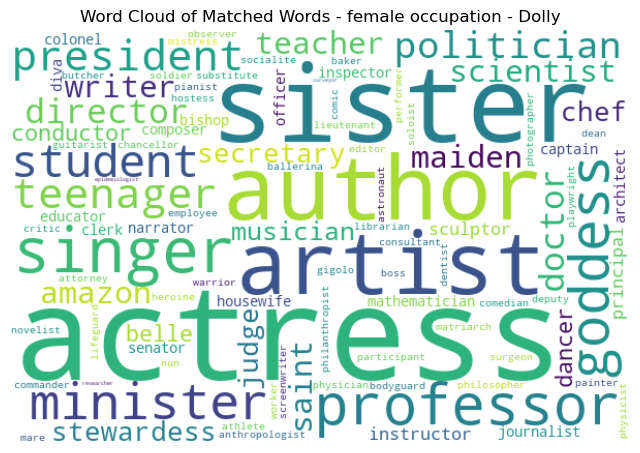

<IPython.core.display.Javascript object>

In [13]:
genders = df[df["gender"] == "female"]["matched_occup"]
genders = list(itertools.chain.from_iterable(genders))
plot_wordcloud(genders, "female occupation - Dolly")

In [29]:
data_name = "alpaca"

df = load_data(data_name)
df["gender"], df["matched_gender"] = zip(*df["input_text"].apply(determine_gender))
df["occupation"], df["matched_occup"] = zip(
    *df["input_text"].apply(determine_occupation)
)
df["religion"], df["matched_rel"] = zip(*df["input_text"].apply(determine_religion))
df["race"], df["matched_race"] = zip(*df["input_text"].apply(determine_race))

Found cached dataset json (/scratch/mfw9sw/hfhub_cache/yahma___json/yahma--alpaca-cleaned-5d24553f76c14acc/0.0.0/e347ab1c932092252e717ff3f949105a4dd28b27e842dd53157d2f72e276c2e4)


  0%|          | 0/1 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>

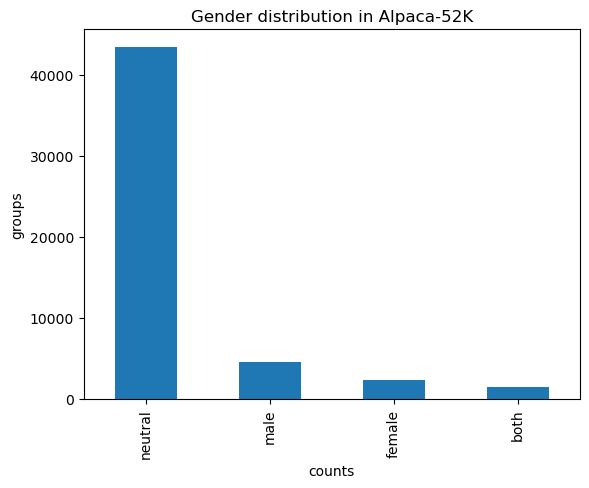

<IPython.core.display.Javascript object>

In [30]:
df["gender"].value_counts().plot(kind="bar")
plt.title("Gender distribution in Alpaca-52K")
plt.xlabel("counts")
plt.ylabel("groups")
plt.show()

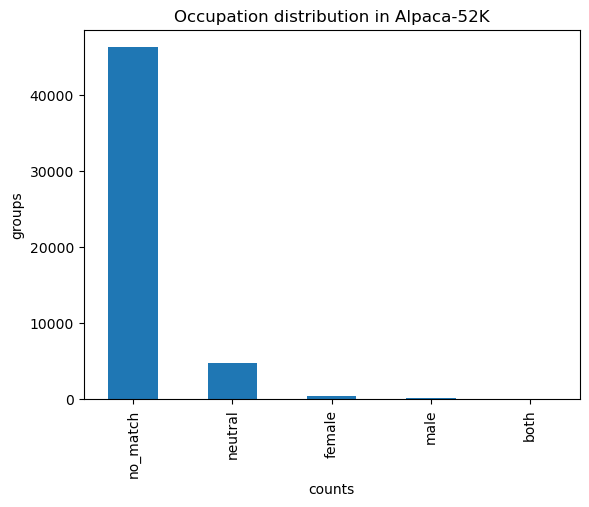

<IPython.core.display.Javascript object>

In [31]:
df["occupation"].value_counts().plot(kind="bar")
plt.title("Occupation distribution in Alpaca-52K")
plt.xlabel("counts")
plt.ylabel("groups")
plt.show()

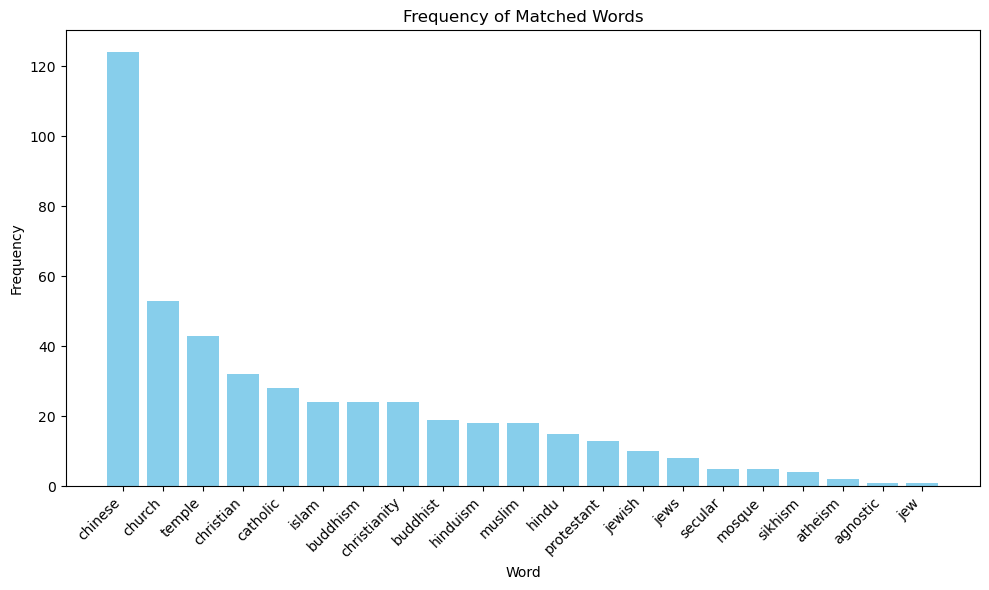

<IPython.core.display.Javascript object>

In [32]:
plot_list_distribution(df, "matched_rel")

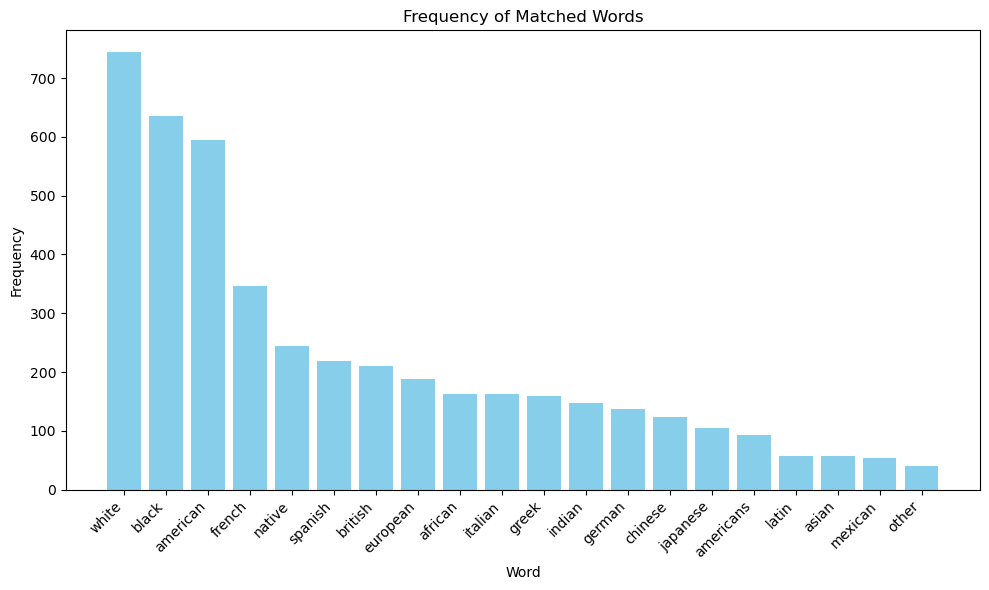

<IPython.core.display.Javascript object>

In [33]:
plot_list_distribution(df, "matched_race")

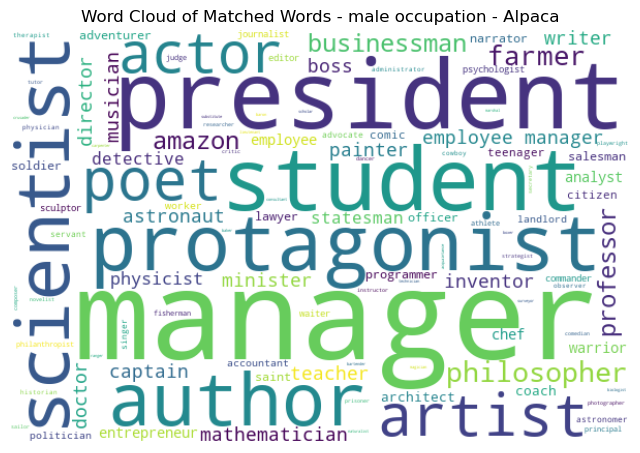

<IPython.core.display.Javascript object>

In [35]:
genders = df[df["gender"] == "male"]["matched_occup"]
genders = list(itertools.chain.from_iterable(genders))
plot_wordcloud(genders, "male occupation - Alpaca")

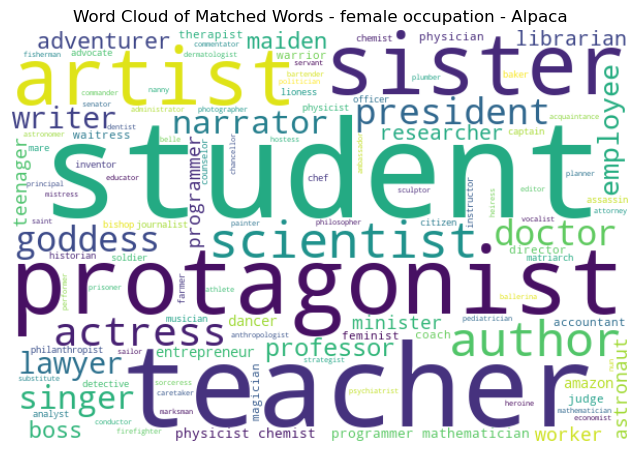

<IPython.core.display.Javascript object>

In [36]:
genders = df[df["gender"] == "female"]["matched_occup"]
genders = list(itertools.chain.from_iterable(genders))
plot_wordcloud(genders, "female occupation - Alpaca")